# Define business requirement
#### By Ahmad & Hanni

**Hypothesis**:  
*States with more relaxed gun ownership regulations experience a higher frequency of school shootings compared to states with stricter gun control policies.*

## Data collection

*Here I am importing the needed libraries:*

In [614]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import graphviz
from sklearn import metrics, tree, model_selection
from scipy.stats import pearsonr
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from scipy.spatial.distance import cdist

*Next I am loading the data into a dataframe using pandas library.*

In [616]:
df = pd.read_csv('Mass shooting data.csv')

## Data cleaning

*Now I am having a look at the dataframe:*

In [619]:
df

,Incident ID,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,1978561,"April 15, 2021",District of Columbia,Washington,1800 block of West Virginia Ave NE,0,4,NaN
1,1978635,"April 15, 2021",Indiana,Indianapolis,8951 Mirabel Rd,8,5,NaN
2,1978652,"April 15, 2021",Illinois,Chicago,600 block of N Sawyer Ave,0,4,NaN
3,1978616,"April 15, 2021",Florida,Pensacola,700 Truman Ave,0,6,NaN
4,1976538,"April 13, 2021",Maryland,Baltimore,2300 block of Hoffman St,0,4,NaN
...,...,...,...,...,...,...,...,...
1995,634238,"August 20, 2016",Connecticut,Hamden,903 Dixwell Ave,0,4,NaN
1996,634731,"August 20, 2016",Washington,Tacoma,900 block of Pacific Avenue,0,5,NaN
1997,634819,"August 20, 2016",Alabama,Citronelle,Jim Platt Road,5,0,NaN
1998,632747,"August 18, 2016",Connecticut,Waterbury,402 E Main Street,0,4,NaN


*Now I want to extend the information from the dataframe:*

In [621]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Incident ID     2000 non-null   int64  
 1   Incident Date   2000 non-null   object 
 2   State           2000 non-null   object 
 3   City Or County  2000 non-null   object 
 4   Address         1997 non-null   object 
 5   # Killed        2000 non-null   int64  
 6   # Injured       2000 non-null   int64  
 7   Operations      0 non-null      float64
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


*Since I don't want to use the following columns:*

*Operations*  
*Address*  
*City Or County*  
*Incident ID*  

*I will be deleting them since they won't affect my hypothesis.*

In [623]:
df = df.drop(['Operations', 'Address', 'City Or County', 'Incident ID'], axis=1)

*Let's see, how our dataframe looks now:*

In [625]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Incident Date  2000 non-null   object
 1   State          2000 non-null   object
 2   # Killed       2000 non-null   int64 
 3   # Injured      2000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 62.6+ KB


*I only want to keep the year in my data column:*

In [627]:
df['Incident Date'] = pd.to_datetime(df['Incident Date'])
df['year'] = df['Incident Date'].dt.year
df = df.drop('Incident Date', axis=1)

*Data score collected from: https://everytownresearch.org/rankings/*  
*Now I want to add for each state their law strictness score:*

In [629]:
weapon_law_mapping = {
    'Alabama': 12.50, 'Alaska': 9.00, 'Arizona': 8.50, 'Arkansas': 3.00, 'California': 89.50,
    'Colorado': 63.00, 'Connecticut': 82.50, 'Delaware': 61.50, 'District of Columbia': 69.00,
    'Florida': 27.50, 'Georgia': 5.00, 'Idaho': 5.00, 'Illinois': 83.00, 'Indiana': 16.50,
    'Iowa': 15.50, 'Kansas': 9.50, 'Kentucky': 9.00, 'Louisiana': 20.50, 'Maine': 20.50,
    'Maryland': 75.00, 'Massachusetts': 81.00, 'Michigan': 35.00, 'Minnesota': 53.50,
    'Mississippi': 3.00, 'Missouri': 9.00, 'Montana': 5.00, 'Nebraska': 25.00, 'Nevada': 35.00,
    'New Jersey': 79.00, 'New Mexico': 40.50, 'New York': 83.50, 'North Carolina': 25.00,
    'Ohio': 13.00, 'Oklahoma': 7.50, 'Oregon': 68.00, 'Pennsylvania': 40.00, 'South Carolina': 18.00,
    'South Dakota': 5.00, 'Tennessee': 16.50, 'Texas': 13.50, 'Utah': 12, 'Virginia': 49.00,
    'Washington': 69.00, 'West Virginia': 18.50, 'Wisconsin': 28.00, 'Wyoming': 6.50
}

df['Weapon law strictness score'] = df['State'].map(weapon_law_mapping)

*I can conclude that my data has been cleaned and is ready for exploration and analysis.*

## Data Exploration & Analysis

*To start with I want to just have a look at how the dataframe looks:*

In [633]:
df

,State,# Killed,# Injured,year,Weapon law strictness score
0,District of Columbia,0,4,2021,69.0
1,Indiana,8,5,2021,16.5
2,Illinois,0,4,2021,83.0
3,Florida,0,6,2021,27.5
4,Maryland,0,4,2021,75.0
...,...,...,...,...,...
1995,Connecticut,0,4,2016,82.5
1996,Washington,0,5,2016,69.0
1997,Alabama,5,0,2016,12.5
1998,Connecticut,0,4,2016,82.5


*Here I am getting the first 5 rows:*

In [635]:
df.head()

,State,# Killed,# Injured,year,Weapon law strictness score
0,District of Columbia,0,4,2021,69.0
1,Indiana,8,5,2021,16.5
2,Illinois,0,4,2021,83.0
3,Florida,0,6,2021,27.5
4,Maryland,0,4,2021,75.0


*Here I am getting 5 random rows:*

In [637]:
df.sample(5)

,State,# Killed,# Injured,year,Weapon law strictness score
1862,Illinois,3,4,2016,83.0
1948,Texas,1,4,2016,13.5
417,Colorado,1,4,2020,63.0
1009,Louisiana,0,4,2019,20.5
921,California,0,4,2019,89.5


*Here I am getting the last 5 rows:*

In [639]:
df.tail()

,State,# Killed,# Injured,year,Weapon law strictness score
1995,Connecticut,0,4,2016,82.5
1996,Washington,0,5,2016,69.0
1997,Alabama,5,0,2016,12.5
1998,Connecticut,0,4,2016,82.5
1999,California,0,4,2016,89.5


*Here I am getting all the columns names printed out:*

In [641]:
df.columns

Index(['State', '# Killed', '# Injured', 'year',
       'Weapon law strictness score'],
      dtype='object')

*Here I am printing how many rows, columns and the size of my data:*

In [643]:
print('Rows: {} Columns: {} Size: {}'.format(df.shape[0], df.shape[1], df.size))

Rows: 2000 Columns: 5 Size: 10000


*Here I am printing the descriptive statistics information:*

In [645]:
df.describe()

,# Killed,# Injured,year,Weapon law strictness score
count,2000.000000,2000.00000,2000.000000,2000.000000
mean,1.051000,4.27500,2018.722500,42.709000
std,2.106803,10.00187,1.424257,31.438842
min,0.000000,0.00000,2016.000000,3.000000
25%,0.000000,3.00000,2018.000000,13.500000
50%,1.000000,4.00000,2019.000000,27.500000
75%,1.000000,5.00000,2020.000000,82.500000
max,59.000000,441.00000,2021.000000,89.500000


*Here I am creating histograms:*

array([[<Axes: title={'center': '# Killed'}>,
        <Axes: title={'center': '# Injured'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'Weapon law strictness score'}>]],
      dtype=object)

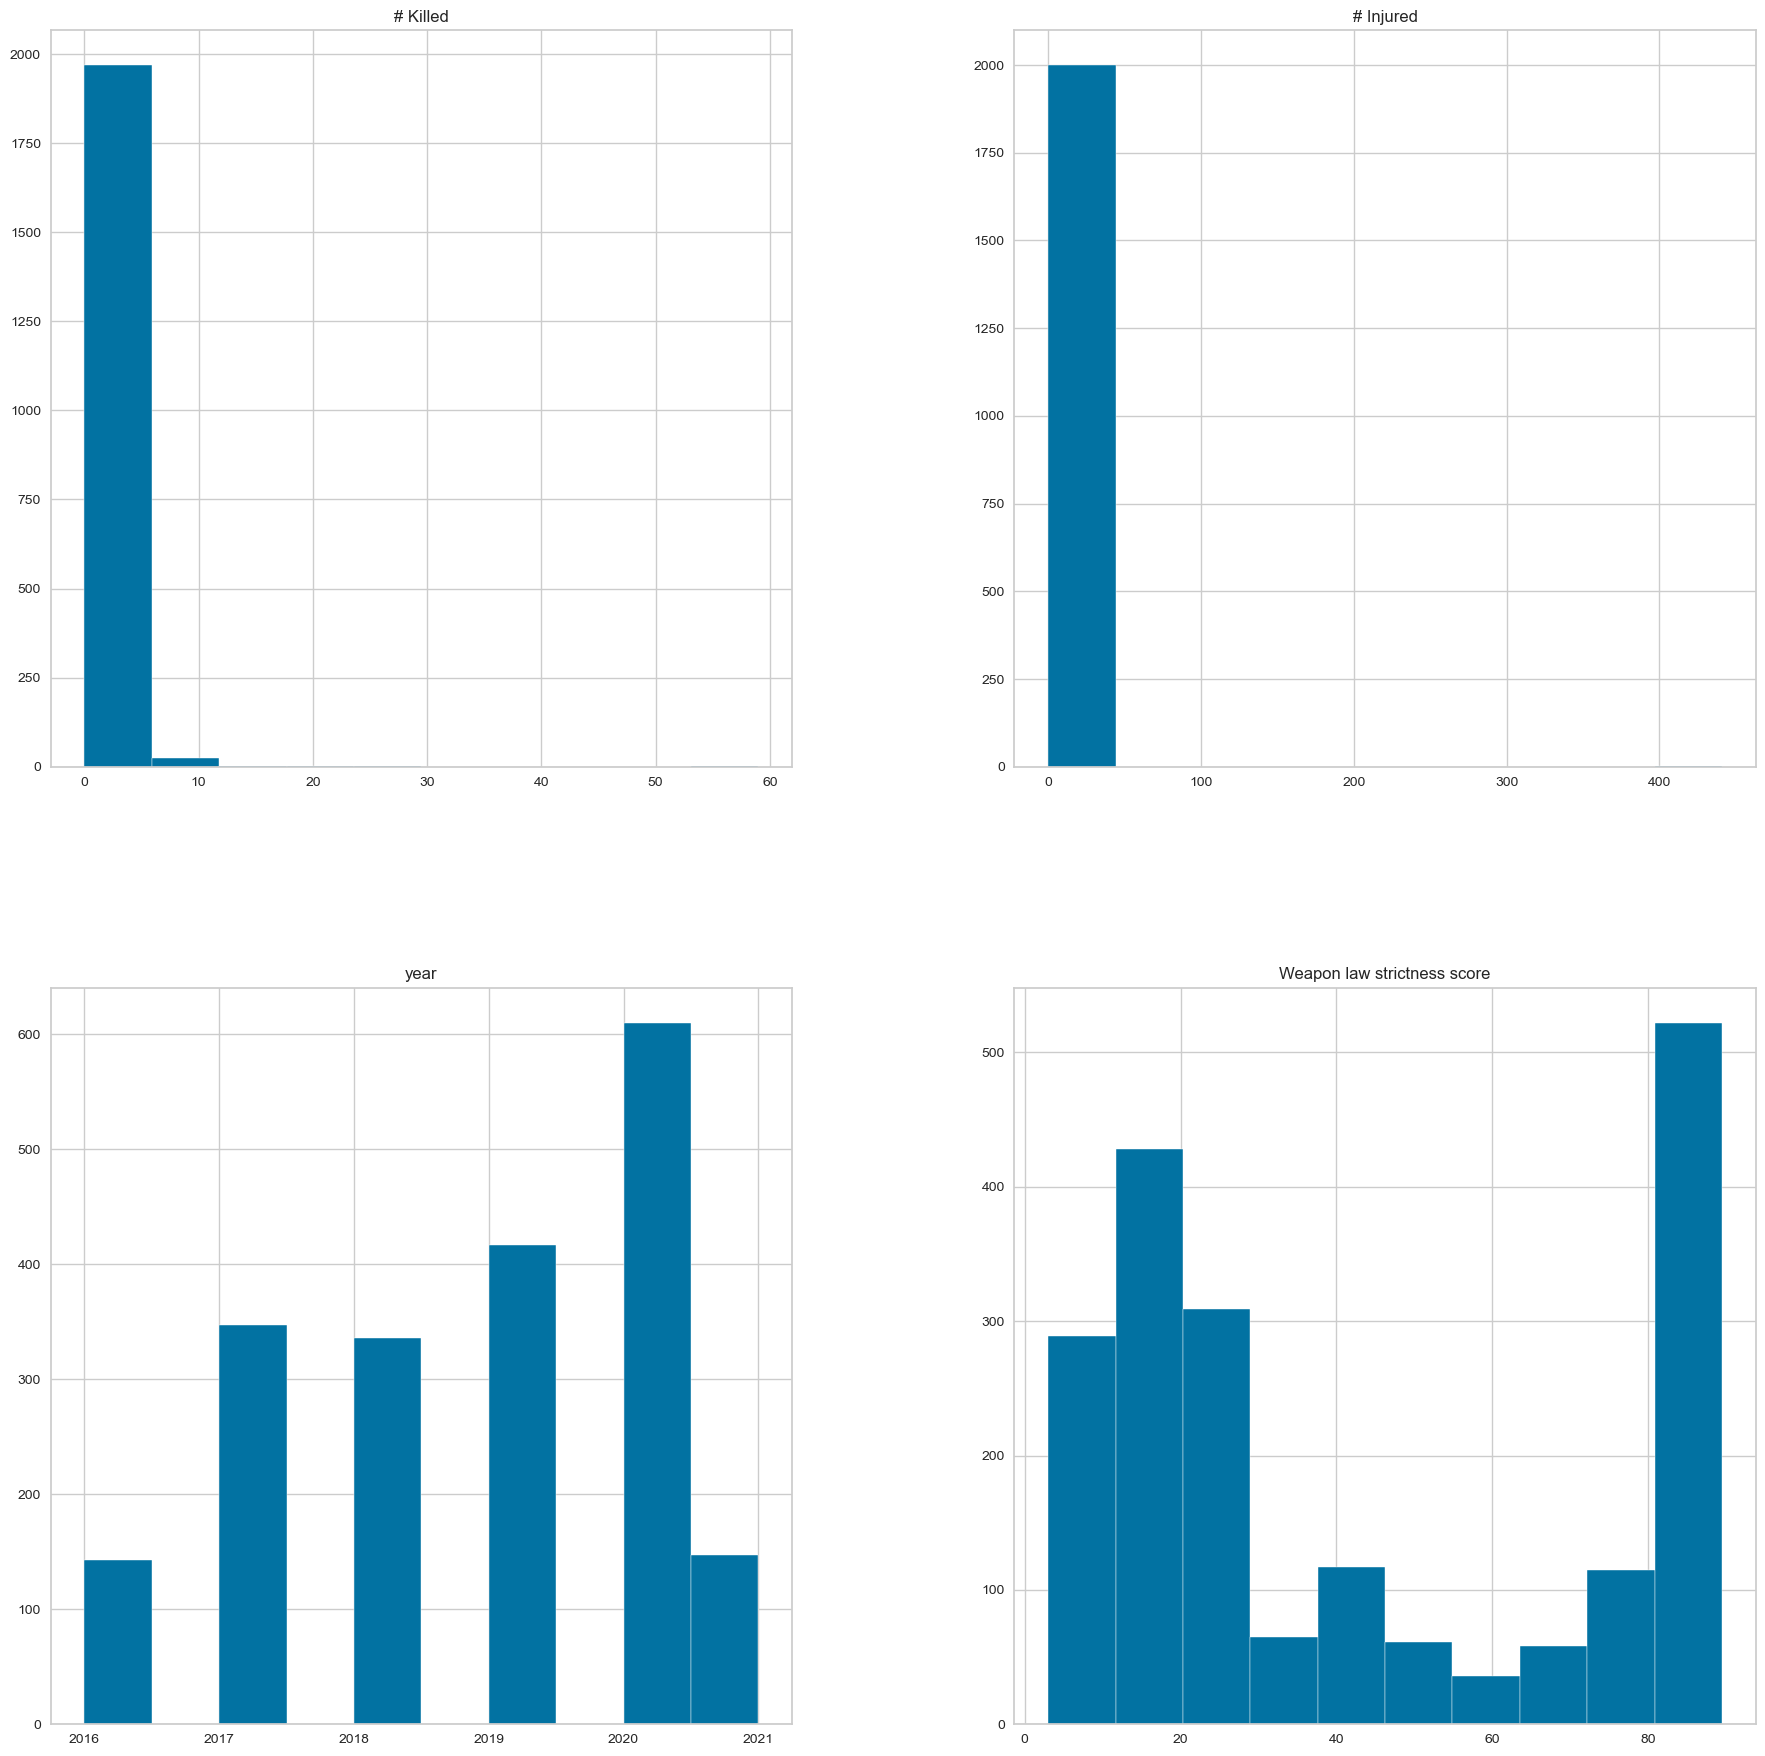

In [647]:
df.hist(figsize=(22, 22))

*I can conclude that none of them are normally distributed.*

*Here I am grouping by states to get the maximum number of killings for each state:*

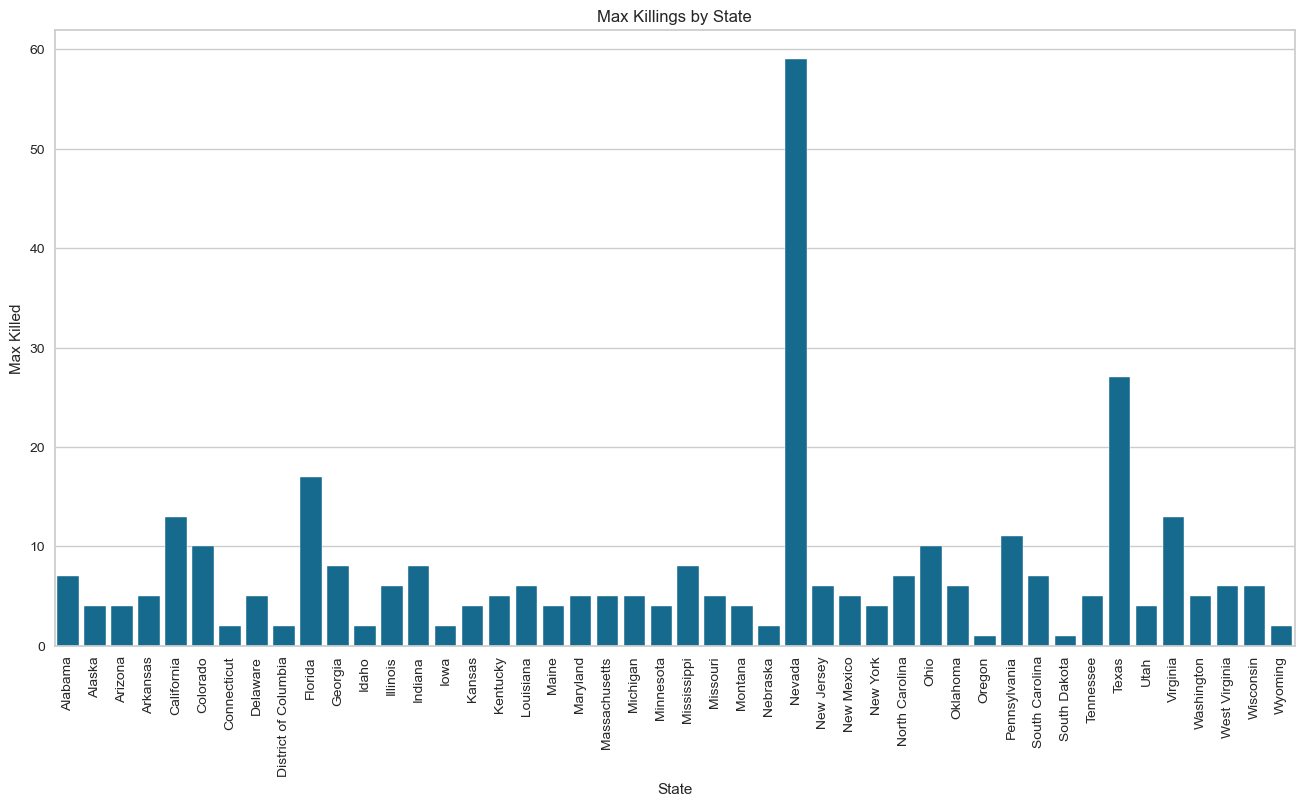

In [650]:
df_grouped = df.groupby('State')['# Killed'].max().reset_index()
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
sns.barplot(x='State', y='# Killed', data=df_grouped)
plt.xticks(rotation=90)
plt.title('Max Killings by State')
plt.xlabel('State')
plt.ylabel('Max Killed')
plt.show()

*I can conclude that Nevada has the maximum killings of an incident.*

*Here I am grouping by states to get the maximum number of injured of an incident for each state.*

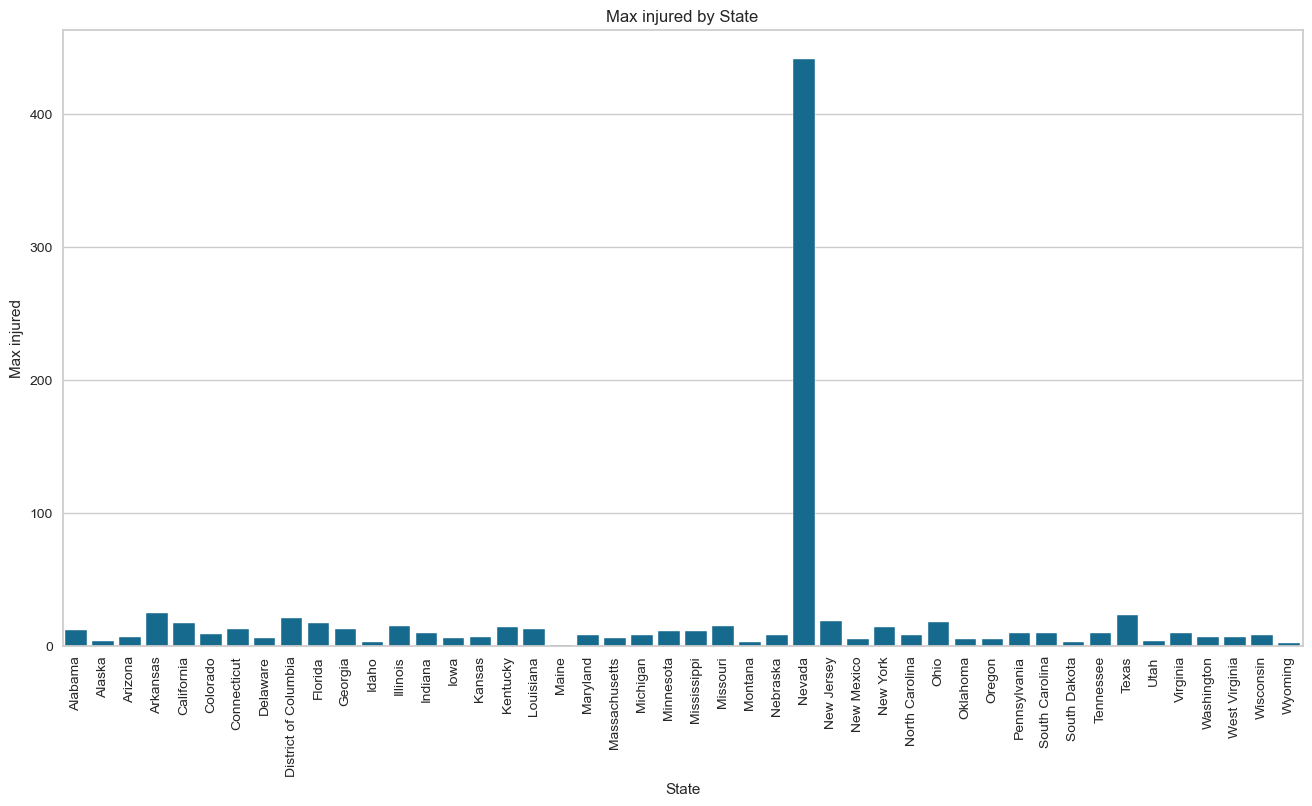

In [653]:
df_grouped = df.groupby('State')['# Injured'].max().reset_index()
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))
sns.barplot(x='State', y='# Injured', data=df_grouped)
plt.xticks(rotation=90)
plt.title('Max injured by State')
plt.xlabel('State')
plt.ylabel('Max injured')
plt.show()

*We can conclude that Nevada has the most injured of an incident.*

*I now want to display the number of school shootings per state:*

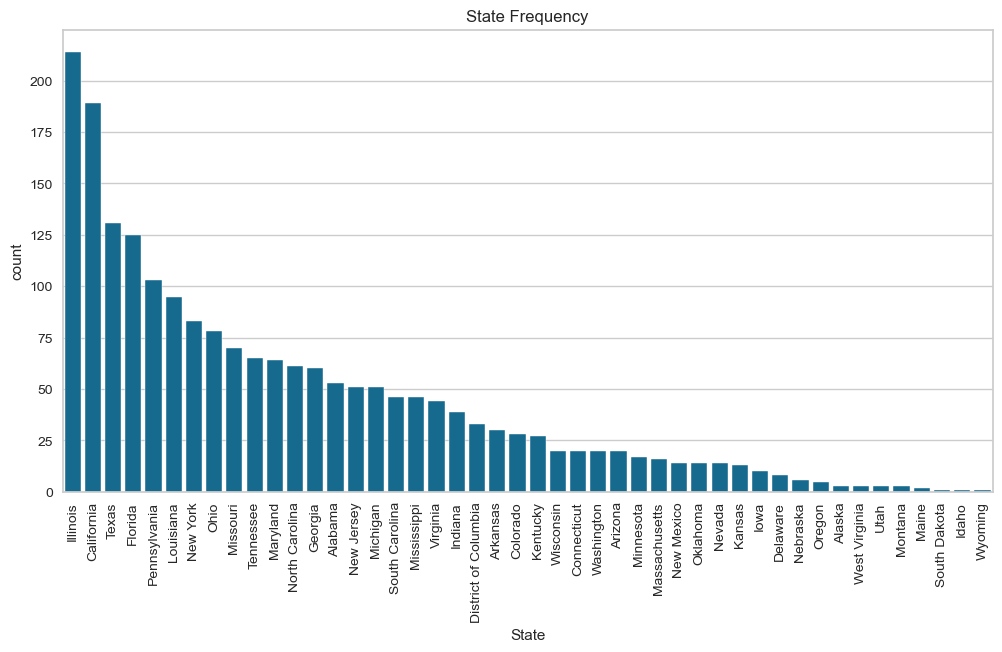

In [656]:
plt.figure(figsize=(12, 6))
sns.countplot(x='State', data=df, order=df['State'].value_counts().index)
plt.title('State Frequency')
plt.xticks(rotation=90)
plt.show()

*I can conclude that Illinois has the most shootings.*

*Here I am creating box and whiskers plot of the killings in each accident + showing the mean:*

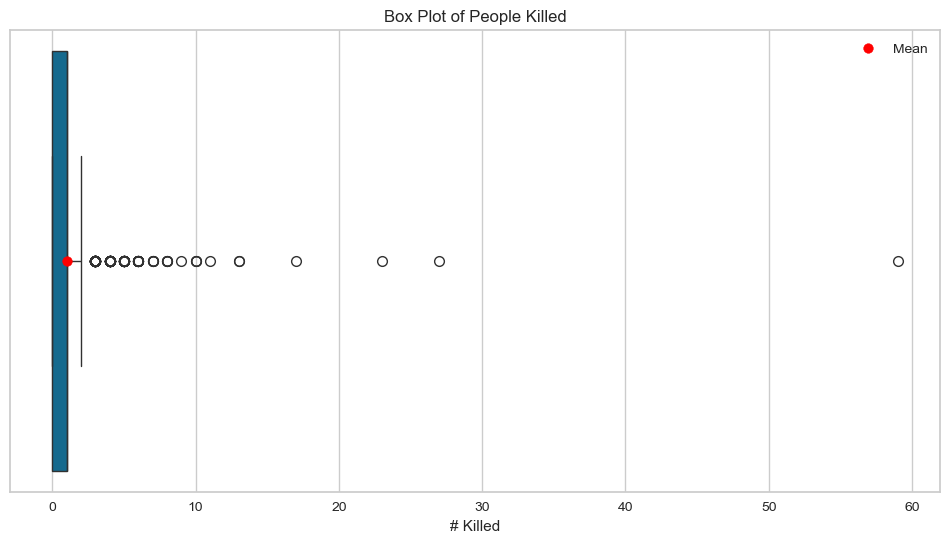

In [659]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='# Killed', data=df)
mean_value = df['# Killed'].mean()
plt.scatter(mean_value, 0, color='red', zorder=10, label='Mean')
plt.title('Box Plot of People Killed')
plt.legend()
plt.show()

*I can conclude that most of the shootings have 0 or 1 killed, and that anything above 2 killed is an outlier.*

*Here I am grouping by states to get the number of incidents:*

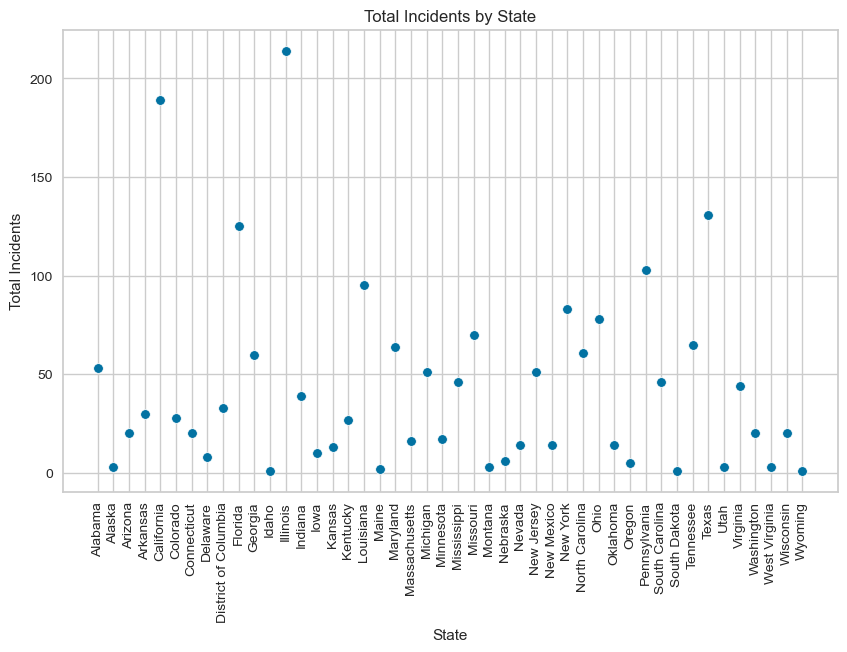

In [662]:
df_grouped = df.groupby('State').size().reset_index(name='Total Incidents')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='State', y='Total Incidents', data=df_grouped)
plt.xticks(rotation=90)
plt.title('Total Incidents by State')
plt.xlabel('State')
plt.ylabel('Total Incidents')
plt.show()

*I can conclude that Illinois has the most shootings.*

*Here I am grouping by states to get the total number of injured:*

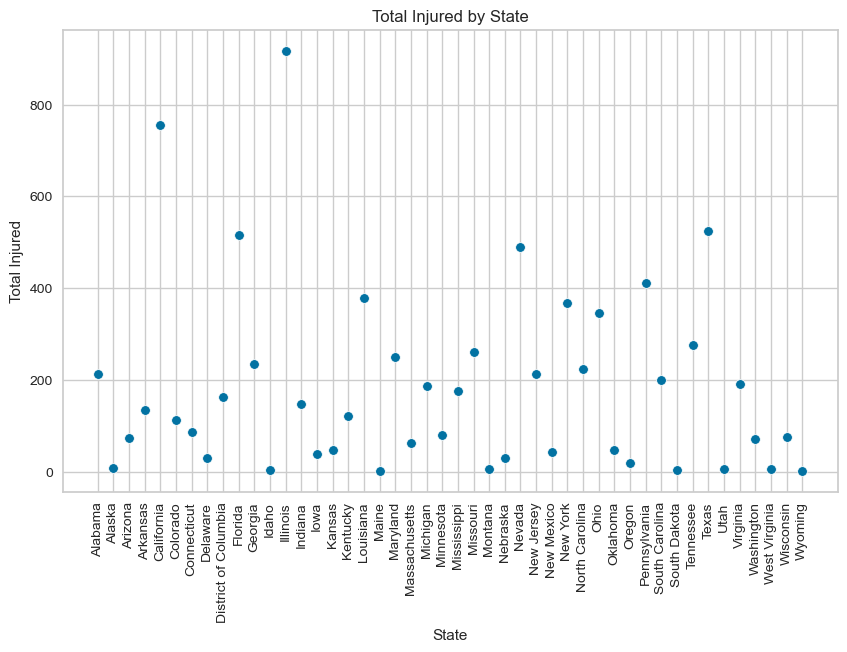

In [665]:
df_grouped = df.groupby('State')['# Injured'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='State', y='# Injured', data=df_grouped)
plt.title('Total Injured by State')
plt.xlabel('State')
plt.ylabel('Total Injured')
plt.xticks(rotation=90)
plt.show()

*I can conclude that Illinois has the most injured.*

*Here I am grouping by states to get the total number of killed:*

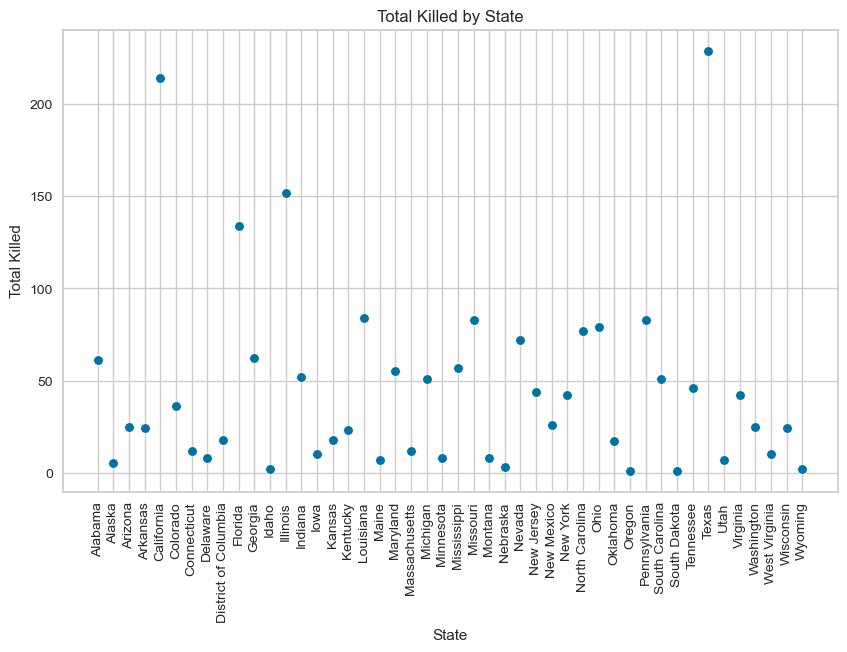

In [668]:
df_grouped = df.groupby('State')['# Killed'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='State', y='# Killed', data=df_grouped)
plt.title('Total Killed by State')
plt.xlabel('State')
plt.ylabel('Total Killed')
plt.xticks(rotation=90)
plt.show()

*I can conclude that Texas has the most killed.*

*Here I am grouping by state and summing the 'injured' and 'killed' values.*

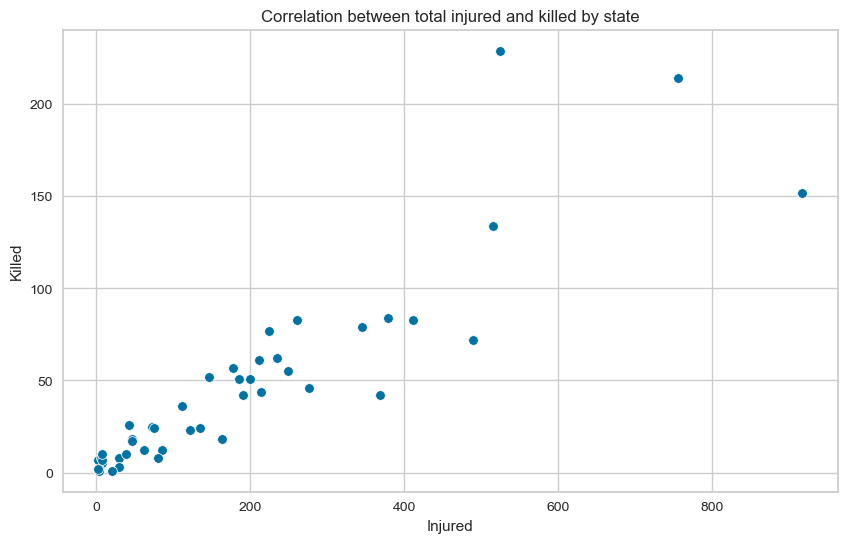

In [671]:
df_injured = df.groupby('State')['# Injured'].sum().reset_index()
df_killed = df.groupby('State')['# Killed'].sum().reset_index()
df_grouped = pd.merge(df_injured, df_killed, on='State')

plt.figure(figsize=(10, 6))
sns.scatterplot(x='# Injured', y='# Killed', data=df_grouped)
plt.title('Correlation between total injured and killed by state')
plt.xlabel('Injured')
plt.ylabel('Killed')
plt.show()

*I can conclude that there's an correlation between injured and killed. The more injured the more is killed.*

*Here I am showing correlation heatmap of the dataframe. But first I will one-hot encode my column state, to be able to see it in my
heatmap.*

In [674]:
label_encoder = LabelEncoder()
df['State'] = label_encoder.fit_transform(df['State'])

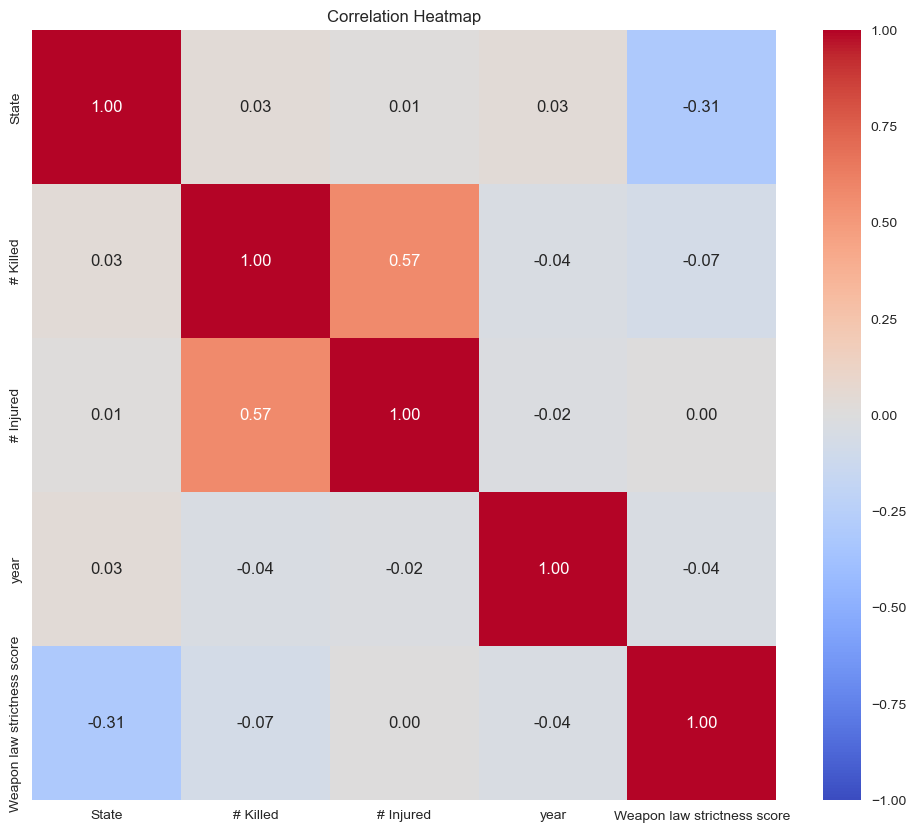

In [675]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

*I can conclude that there is an high correlation between injured and killed, while the rest has no correlation.*

# Data modellering

## Linear Regression (Numeric)

1) *First I will shuffle the data:*

In [680]:
df_shuffled = shuffle(df, random_state=42)

2) *Now I creating the dependent and independent variabels:*

In [682]:
DV = '# Killed' 
X = df_grouped[['# Injured']] 
y = df_grouped[DV]

3) *Now I am splitting the data using the following model, which I then I will use to train a new model:*

In [684]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

4) *I am now creating an LineLinearRegression object:*

In [686]:
model = LinearRegression()

5) *Now I am training my model:*

In [688]:
model.fit(X_train[['# Injured']], y_train)

LinearRegression()

*Here I am printing out the following:*

* *Interception*
* *Coefficient*
* *The model*

In [690]:
print('Interception: ', model.intercept_)
print('Coefficient: ', model.coef_)
print('The formula: Killed = {0:0.2f} + ({1:0.2f} x injured)'.format(model.intercept_, model.coef_[0]))

Interception:  6.517309380268756
Coefficient:  [0.20040758]
The formula: Killed = 6.52 + (0.20 x injured)


6) *I now want to try my model:*

In [692]:
y_predictions = model.predict(X_test[['# Injured']])

7) *Now I am comparing my y_predictions with my real y.*

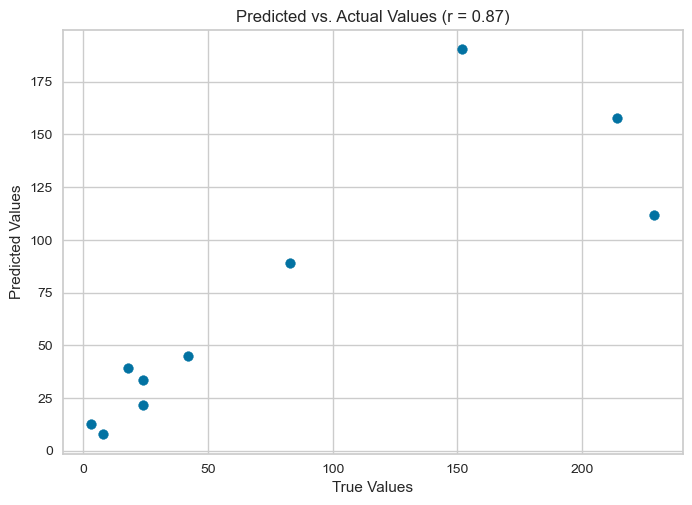

In [694]:
plt.scatter(y_test, y_predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (r = {0:0.2f})'.format(pearsonr(y_test, y_predictions)[0]))
plt.show()

*I can now conclude that there is an strong correlation between the predicted and true values.*

8) *Here I creating my metrics dataframe:*

In [697]:
metrics_df = pd.DataFrame({'Metric': ['MAE', 
                                      'MSE', 
                                      'RMSE', 
                                      'R-Squared'],
                          'Value': [metrics.mean_absolute_error(y_test, y_predictions),
                                    metrics.mean_squared_error(y_test, y_predictions),
                                    np.sqrt(metrics.mean_squared_error(y_test, y_predictions)),
                                    metrics.explained_variance_score(y_test, y_predictions)]}).round(3)

*I am here printing out my metrics dataframe:*

In [699]:
metrics_df

,Metric,Value
0,MAE,26.363
1,MSE,1905.591
2,RMSE,43.653
3,R-Squared,0.731


*I can conclude that my model is 73,1 % accurate.*

# Multiple Regression (Nominal)

1) *First I will shuffle the data:*

In [703]:
df_shuffled = shuffle(df, random_state=42)

2) *Then I am creating the dependent and independent variabels.*

In [705]:
DV = '# Killed'
X = df_shuffled[['# Injured', 'State']]  
y = df_shuffled[DV]

3) *Now I am splitting my data using the following model:*

In [707]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

4) *Now I am creating an object of LinearRegression.*

In [709]:
model = LinearRegression()

5) *Now I am training my model:*

In [711]:
model.fit(X_train, y_train)

LinearRegression()

*Here I am printing out the following:*

* *Interception*
* *Coefficient*
* *The formula*

In [713]:
print('Intercept:', model.intercept_)
print('Coefficients:', model.coef_)
feature_names = X.columns
equation = ' + '.join(f'({coef:0.2f} x {name})' for coef, name in zip(model.coef_, feature_names))
print(f'Killed = {model.intercept_:0.2f} + {equation}')

Intercept: 0.4945323379924229
Coefficients: [0.12057542 0.00250672]
Killed = 0.49 + (0.12 x # Injured) + (0.00 x State)


6) *Now I am testing my model:*

In [715]:
y_predictions = model.predict(X_test)

7) *Now I am plotting the correlation of predicted and actual values in a scatterplot:*

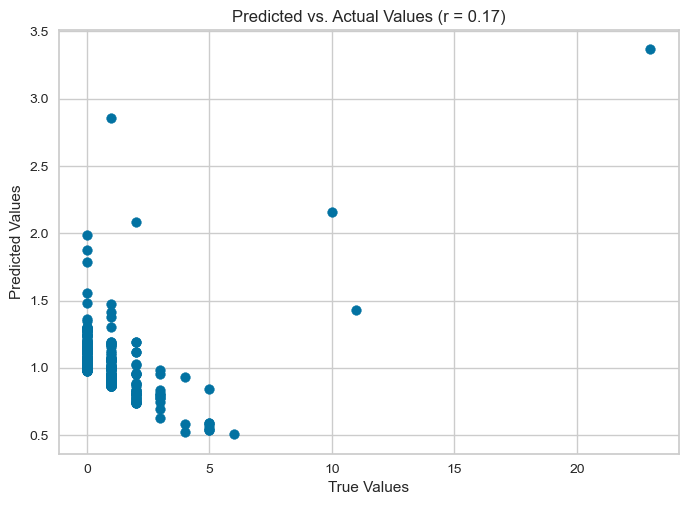

In [717]:
plt.scatter(y_test, y_predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (r = {0:0.2f})'.format(pearsonr(y_test, y_predictions)[0]))
plt.show()

*I can conclude that there is a insufficient correlation between predicted and true values.*

8) *Now I am creating the metrics dataframe:*

In [720]:
metrics_df = pd.DataFrame({'Metric': ['MAE', 
                                      'MSE', 
                                      'RMSE', 
                                      'R-Squared'],
                          'Value': [metrics.mean_absolute_error(y_test, y_predictions),
                                    metrics.mean_squared_error(y_test, y_predictions),
                                    np.sqrt(metrics.mean_squared_error(y_test, y_predictions)),
                                    metrics.explained_variance_score(y_test, y_predictions)]}).round(3)

*Printing out the metrics dataframe:*

In [722]:
metrics_df

,Metric,Value
0,MAE,1.068
1,MSE,3.417
2,RMSE,1.849
3,R-Squared,0.029


*I can conclude that my model is 2,9 % accurate.*

# Polynominal Regression

1) *Here I shuffling the my data:*

In [726]:
df_shuffled = shuffle(df_grouped, random_state=42)

2) *Then I am creating the dependent and independent variabels:*

In [728]:
DV = '# Killed'
X = df_shuffled[['# Injured']]  
y = df_shuffled[DV] 

3) *Then I am splitting my data:*

In [730]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

4) *Now I feature scale my data:*

In [732]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

5) *Now I fit the Polynomial Regression model.*

In [734]:
pol_reg = LinearRegression()
pol_reg.fit(X_train_poly, y_train)

LinearRegression()

6) *Now I test my model.*

In [736]:
y_predict = pol_reg.predict(X_test_poly)

7) *Now I plot my model into a scatterplot:*

In [738]:
def viz_polynomial():
    plt.scatter(X_test, y_test, color='red', label='Actual Data')
    plt.plot(X_test, y_predict, color='blue', label='Polynomial Regression')
    plt.title('Polynomial Regression')
    plt.xlabel('# Injured')
    plt.ylabel('# Killed')
    plt.legend()
    plt.show()

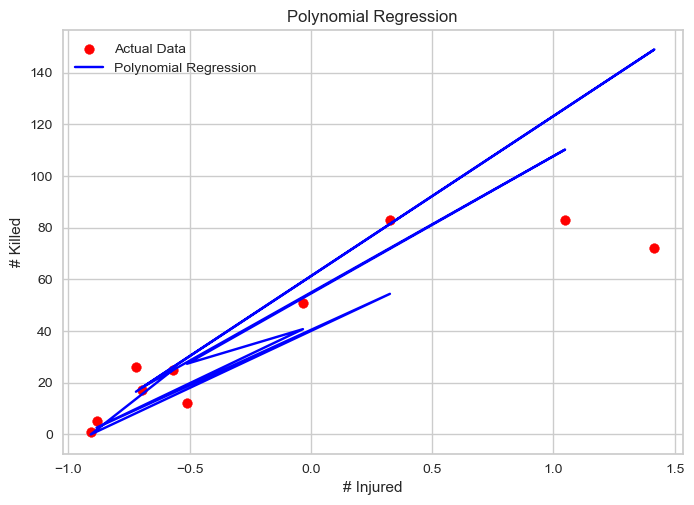

In [739]:
viz_polynomial()

*I can conclude that my model looks insufficient to use.*

8) *Now I calculate the metrics dataframe:*

In [742]:
metrics_dict = {
    'MAE': metrics.mean_absolute_error(y_test, y_predict),
    'MSE': metrics.mean_squared_error(y_test, y_predict),
    'RMSE': np.sqrt(metrics.mean_squared_error(y_test, y_predict)),
    'R-Squared': metrics.r2_score(y_test, y_predict)
}

*Printing out the metrics dataframe:*

In [744]:
metrics_dict

{'MAE': 17.266463873791334,
 'MSE': 792.6510498734336,
 'RMSE': 28.154059207748954,
 'R-Squared': 0.14405156322721924}

*I can conclude that my model is 14,40% accurate.*

# Clustering

1) *Here I am creating the variabel needed for the clustering:*

In [748]:
X = (df[['State', '# Killed', '# Injured', 'year', 'Weapon law strictness score']])

2) *Taking a look at the variabel:*

In [750]:
X

,State,# Killed,# Injured,year,Weapon law strictness score
0,8,0,4,2021,69.0
1,13,8,5,2021,16.5
2,12,0,4,2021,83.0
3,9,0,6,2021,27.5
4,19,0,4,2021,75.0
...,...,...,...,...,...
1995,6,0,4,2016,82.5
1996,42,0,5,2016,69.0
1997,0,5,0,2016,12.5
1998,6,0,4,2016,82.5


3) *Calculating the distortions:*

In [752]:
distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init="auto").fit(X)
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]) 
print("Distortion: ", distortions)

Distortion:  [14.944930627906603, 12.860818931708625, 11.91744017037691, 11.18856545299115, 8.924006989561422, 8.309444753652956, 7.0867496246913495, 6.458624313086591]


4) *Here I am showing the elbow diagram to see the optimal number of clusters:*

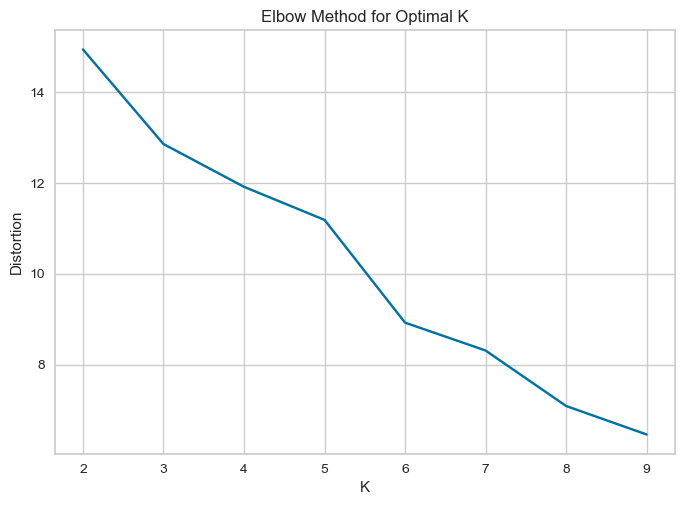

In [754]:
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

*I can here conclude that the optimal of clusters would be: 6*

5) *Here I determine the number of max clusters using the silhouette score method.*

In [757]:
scores = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X)
    score = metrics.silhouette_score(X, model.labels_, metric='euclidean', sample_size=len(X))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.6688986916550734

Number of clusters = 3
Silhouette score = 0.6717488418612734

Number of clusters = 4
Silhouette score = 0.5367265653335527

Number of clusters = 5
Silhouette score = 0.5491193069911228

Number of clusters = 6
Silhouette score = 0.49835067823807233

Number of clusters = 7
Silhouette score = 0.4969138340696227

Number of clusters = 8
Silhouette score = 0.5223510239285963

Number of clusters = 9
Silhouette score = 0.5298861433255484


*Here again I am showing the elbow diagram by silhouette score method.*

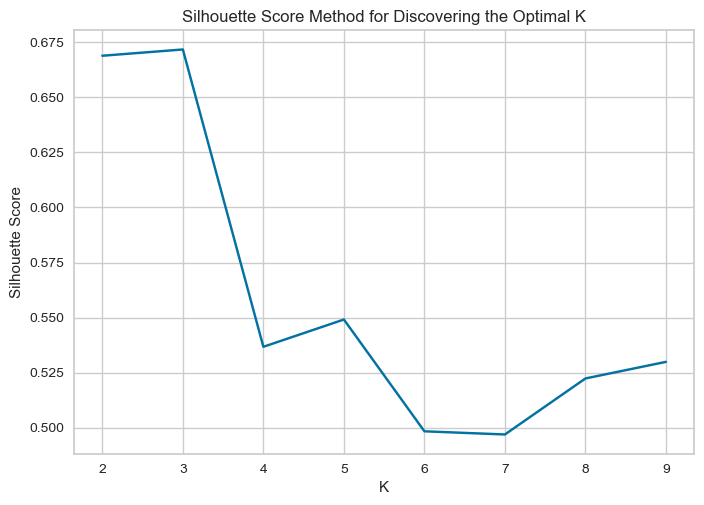

In [759]:
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

*I can here conclude that the optimal number of clusters would be: 3*

*Time to create the model:*

1) *Variabel to hold our number of clusters.*

In [763]:
num_clusters = 3

2) *Creating the model:*

In [765]:
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init="auto")

3) *Training the model with my data:*

In [767]:
kmeans.fit(X)

KMeans(n_clusters=3)

4) *Printing out the labels:*

In [769]:
np.set_printoptions(threshold=np.inf)
kmeans.labels_

array([1, 2, 1, 2, 1, 1, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2,
       2, 0, 0, 2, 0, 2, 1, 1, 0, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 1,
       0, 0, 0, 0, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0,
       2, 2, 1, 0, 1, 1, 0, 0, 2, 1, 0, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 1,
       1, 2, 2, 0, 2, 1, 2, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 0, 1,
       2, 0, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1,
       0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 0, 2, 0, 1, 0, 1, 0, 2, 2, 0,
       0, 0, 2, 2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 0, 0, 2, 1, 1, 2,
       2, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0,
       2, 1, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 2,
       0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 2, 1, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2,
       1, 1, 2, 2, 0, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1,
       2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,

5) *Here I want to review the clusters:*

C:\Users\baban\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


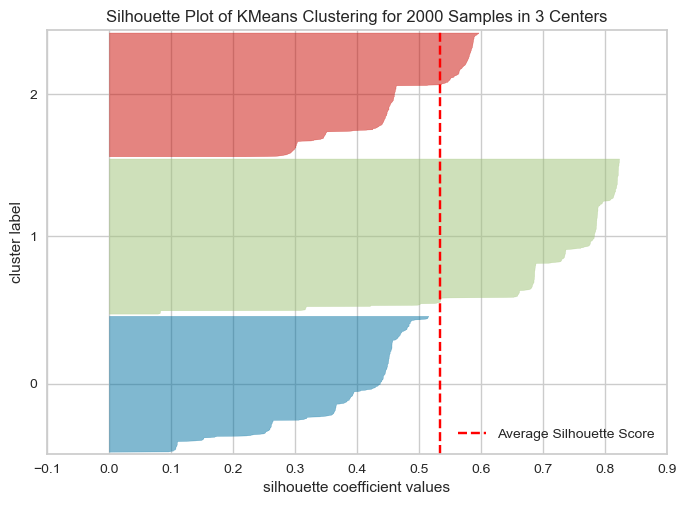

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 2000 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [771]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.show()

*I can conclude that they're not equally in size, but they're above 0,50.*

## Validate the model

1) *Trying out my model:*

In [775]:
test1 = pd.DataFrame([[1, 2, 0, 3, 4]], columns=['State', '# Killed', '# Injured', 'year', 'Weapon law strictness score'])
test2 = pd.DataFrame([[8, 0, 4, 2021, 3]], columns=['State', '# Killed', '# Injured', 'year', 'Weapon law strictness score'])

print(kmeans.predict(test1))
print(kmeans.predict(test2) == 1)

[2]
[False]


2) *I will now divide my data into clusters using my model:*

In [777]:
df['cluster'] = kmeans.predict(df[['State', '# Killed', '# Injured', 'year', 'Weapon law strictness score']])

*I am now ready to use my dataframe for classification.*

## Decision-Tree-Classification

1) *Here I am Converting the data into an array.*

In [781]:
array = df.values

2) *Now I will divide the data into dependent and independent values:*

In [783]:
X, y = array[:,:-1], array[:,-1]

3) *Separating my input data into classes based on labels:*

In [785]:
class0 = np.array(X[y==0])
class1 = np.array(X[y==1])
class2 = np.array(X[y==2])
class3 = np.array(X[y==3])
class4 = np.array(X[y==4])
class5 = np.array(X[y==5])
class6 = np.array(X[y==6])

4) *Initiating two variabels for the model:*
* *set_prop = data left for comparing the model.*
* *seed = random value to always get the same random numbere, when splitting the data.*

In [787]:
set_prop = 0.2
seed = 7

5) *Now I will split the data:*

In [789]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=set_prop, random_state=seed)

6) *Now I am build my decision tree*

In [791]:
params = {'max_depth': 5}
classifier = DecisionTreeClassifier(**params)
classifier.fit(X_train, y_train)
gr_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names = df.columns[:X.shape[1]], class_names = True,        
                         filled=True, rounded=True, proportion = False, special_characters=True)  
dtree = graphviz.Source(gr_data)

7) *Loading my decision tree:*

In [793]:
dtree.render("heart") 

'heart.pdf'

8) *Print out my tree:*

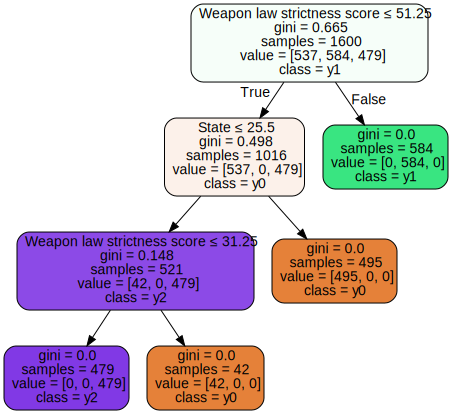

In [795]:
dtree

9) *Testing my model:*

In [797]:
y_testp = classifier.predict(X_test)

10) *Printing out the confusion:*

In [799]:
confusion = pd.crosstab(y_test,y_testp)
confusion

col_0,0.0,1.0,2.0
row_0,,,
0.0,118,0,0
1.0,0,164,0
2.0,0,0,118


In [800]:
print ("Accuracy is ", accuracy_score(y_test,y_testp))

Accuracy is  1.0


*I can conclude that this model's accuracy is 100 %.*

11) *Print out the classification report:*

In [803]:
class_names = ['Class0', 'Class1', 'Class2']
print(classification_report(y_train, classifier.predict(X_train), target_names=class_names))
plt.show()

              precision    recall  f1-score   support

      Class0       1.00      1.00      1.00       537
      Class1       1.00      1.00      1.00       584
      Class2       1.00      1.00      1.00       479

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600



# Naive Bayes Classification

1) *Converting my dataframe into an array:*

In [806]:
array = df.values

2) *Creating two (sub) arrays from the dataframe:*

In [808]:
X = array[:,0:4] 
Y = array[:, 4]

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Y_binned = pd.cut(Y, bins=bins, labels=labels)

3) *Splitting the data using this model:*

In [810]:
test_set_size = 0.2
seed = 7
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y_binned, test_size=test_set_size, random_state=seed)

4) *Building my model:*

In [812]:
model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB()

5) *Testing my model:*

In [814]:
model.score(X_test, Y_test)

0.42

6) *Testing the model*

In [816]:
prediction = model.predict(X_test)

7) *Getting the amount of rows:*

In [818]:
prediction.shape[0]

400

8) *Calculating accuracy of the model for my real data compared with my predictions:*

In [820]:
print(accuracy_score(Y_test, prediction))

0.42


9) *Printing out the classification report:*

In [822]:
cmat = confusion_matrix(Y_test, prediction)
print(cmat)
print(classification_report(Y_test, prediction))

[[ 2 12  1  0  0  0  0 16 24]
 [ 1 59  0  3  0  0  0  0 21]
 [ 3 18  0  0  0  0  0  0 39]
 [ 0 21  0  0  0  0  0  3  5]
 [ 0  8  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0]
 [ 0  3  0  1  0  0  0  0 15]
 [ 1  6  0  1  0  0  0  6 13]
 [ 0 16  1  0  0  0  0  0 97]]
              precision    recall  f1-score   support

           1       0.29      0.04      0.06        55
           2       0.41      0.70      0.52        84
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00         8
           6       1.00      1.00      1.00         4
           7       0.00      0.00      0.00        19
           8       0.24      0.22      0.23        27
           9       0.45      0.85      0.59       114

    accuracy                           0.42       400
   macro avg       0.27      0.31      0.27       400
weighted avg       0.28      0.42      0.31       400



C:\Users\baban\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\baban\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\baban\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

*I can conclude that the model's accuracy is 42%. This makes it worse than the decision tree model.*

# Data Validation

*Since my decision tree model has an higher accuracy, I will continue with that one.*

*Validating my decision tree model:*

In [827]:
k = [[1, 0, 8, 2023, 3]]
my_prediction = classifier.predict(k)
my_prediction

array([2.])

# Deployment and optimization

*Exporting my model:*

In [830]:
joblib.dump(kmeans, 'kmmodel.pkl')

['kmmodel.pkl']

*Loading my model:*

In [832]:
model = joblib.load('kmmodel.pkl')

#### Conclusion

*I can after my analysis conclude that there is no correlation between law strictness and amount of school shootings.*